<a href="https://colab.research.google.com/github/daniilprigozhin/NLRome_Align_Tree/blob/main/Soy_CladeFinder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install Non-Python Dependencies
#@markdown This block takes 4-5 minutes. If it says your session crashed, please run it a second time (the second time is much faster). This is a bug from importing one of the necessary packages onto Colab.

!pip install -q condacolab
import condacolab
condacolab.install()
!conda install -c bioconda hmmer 
!conda install -c bioconda mafft
!pip install Bio
from collections import defaultdict
from Bio import SearchIO
!conda install -c bioconda epa-ng
!conda install -c bioconda gappa
from google.colab import files

In [2]:
#@title Install Python Dependencies

import pandas as pd
import numpy as np

In [3]:
#@title Select Species
Species = "Maize" #@param ["Soy", "Arabidopsis", "Maize"]

%cd /content
!rm -rf NLRome_Align_Tree
!git clone https://github.com/daniilprigozhin/NLRome_Align_Tree
 
%cd NLRome_Align_Tree/
if Species == 'Soy':
  %cd Soy_NLRome
  common = pd.read_csv("Soy_NLRome_GeneTable.txt", sep='\t')
elif Species == "Arabidopsis":
  %cd Atha_NLRome
  common = pd.read_csv("Atha_NLRome_GeneTable.txt", sep = '\t')
else:
  %cd Maize_NLRome
  common = pd.read_csv("Maize_NLRome_GeneTable.txt", sep = '\t')


clades = common[["Clade", "File"]].groupby("Clade").first()
!unzip All_Clades.zip

/content
Cloning into 'NLRome_Align_Tree'...
remote: Enumerating objects: 8875, done.
remote: Counting objects: 100% (8875/8875), done.
remote: Compressing objects: 100% (5543/5543), done.
remote: Total 8875 (delta 3317), reused 8773 (delta 3228), pack-reused 0
Receiving objects: 100% (8875/8875), 68.64 MiB | 18.36 MiB/s, done.
Resolving deltas: 100% (3317/3317), done.
Checking out files: 100% (8784/8784), done.
/content/NLRome_Align_Tree
/content/NLRome_Align_Tree/Maize_NLRome
Archive:  All_Clades.zip
  inflating: All_Clades.hmm          


In [4]:
# Code used from https://github.com/sokrypton/ColabFold
import re
import hashlib

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'MIRKITRRFSISTDRAGFQFRPEGDDGSTSEGIVDITRWFEEIHTDQTAAQLRPEDEDGDISKRIGEIIRRFEEITGDRAALHLGQEDGERNTWSGRDSTWESRVTSHLLDESCVFGRTKEKEHVVKLVKSYSKCPGIHVLPIVGMGGIGKTTVAQMVYREVQESYDLLSWVHVPETFDLRKLAIAITESLSRQPCTYNNFSVVHDVLQQTVLNKRVFLVLDDLWNERQICWQDFLCSLKFADTMTILVTTRSKEVAQLLQTIPHFELGLLPEDHCWQLFQCYAFGHRNIHEESALVQVGRKIMEKCSCLPLAIKSIGCLLRSKMDMQTWMEISDSEFWEYSDNNEEILSALRLSFHRLPGRLKPCFLLCALYPKGEPFTKDDMIHLWTAHGYVQPSGCKTLEKVAGEYFDELNERSLIEMDTYYLVSREGHNYLKKSRVRSPVEISSGEIFDTDVSFYELHIRSLVENFHKGTTESSLPFQLFRLHDMIWDLAKSLSSCLFSAVAVDEGNLYMQNEVQHLFLWLGRGRSKQNTQRGHSELIPISKSRDLFISWINNSLGLESEPFRWRHRSTPRPSHRPQVSDFELLGLSSTALLGIALEAMIQARPDPVQDPMSSARLLAYLPENKHEYILSTQSRRSQLFKIDYLRTLILKQCTFYNIGIYTYLRALILYSCKDSGCIAAIQYLKLLRYLNIRNCDSLTGKNLNHLTQSICHLYSLEKLIVSTCWKEFSIQSCHLFSLRYLQLSVQFNDWSQHPLCHFHNLDTLCLQNCHSIAELPTGIGNLMNLRCLKLIGISEIKKLNHDSLLCQCNNNKCQLMKAIFPALMELELDSLCELQDWCKFQDPDCPKMQSITVRNCNKLRRIPYFGSVRSLMIINSALIGLQLSASNEPSQLQTLDISYCENLESLLGLENLCSLGSLYIAHCPKLFVLRQEKLLFRPQNILIDDCPGLIEWCDEQELYYHVRSYALLFFLF' #@param {type:"string"}
# remove whitespaces
query_sequence = "".join(query_sequence.split())
query_sequence = re.sub(r'[^a-zA-Z]','', query_sequence).upper()

jobname = 'test' #@param {type:"string"}
# remove whitespaces
jobname = "".join(jobname.split())
jobname = re.sub(r'\W+', '', jobname)
jobname_unhashed = jobname
jobname = add_hash(jobname, query_sequence)

%mkdir {jobname}
%cd {jobname}


with open(f"{jobname}.fasta", "w") as text_file:
    text_file.write(">" + jobname_unhashed + "\n%s" % query_sequence)

/content/NLRome_Align_Tree/Maize_NLRome/test_2070a


In [ ]:
#@title Create an Annotated Tree with your protein included
!hmmsearch --domtblout {jobname}.tbl.out ../All_Clades.hmm {jobname}.fasta 

filename = jobname + ".tbl.out"

attribs = ['bias', 'bitscore',  'evalue']

hits = defaultdict(list)
names = []

with open(filename) as handle:
    for queryresult in SearchIO.parse(handle, 'hmmsearch3-domtab'):
      #print(queryresult.id)
      #print(queryresult.accession)
      #print(queryresult.description)
      for hit in queryresult.hsps:
        names.append(queryresult.id)
        for attrib in attribs:
          hits[attrib].append(getattr(hit, attrib))

final = pd.DataFrame.from_dict(hits)
final["Clade"] = names
final.sort_values("bitscore", ascending = False)

#common = pd.read_csv("Soy_NLRome_GeneTable.txt", sep='\t')

final_hv = final.set_index("Clade").join(common[["Clade", "HV", "File"]].groupby("Clade").agg(max), how = 'left', rsuffix = "_other").sort_values("bitscore", ascending = False)
best_afa_file = final_hv.iloc[0,:]["File"]
best_afa = "../" + best_afa_file

!mafft --add {jobname}.fasta --keeplength {best_afa} > {jobname}.updated.afa

clade_oi = common[common["File"] == best_afa_file].iloc[0,:]["Clade"]
tree_oi = best_afa[:best_afa.find("Int")] + "RAxML_bestTree." + clade_oi + ".Raxml.out"
raxml_info_oi = best_afa[:best_afa.find("Int")] + "RAxML_info." + clade_oi + ".Raxml.out"

!epa-ng --split {best_afa} {jobname}.updated.afa --tree {tree_oi} --model {raxml_info_oi}
!cut -f1 -d ' ' {best_afa} > best_afa_f.afa
!epa-ng --ref-msa best_afa_f.afa --tree {tree_oi} -q query.fasta --model {raxml_info_oi} --redo

!gappa examine graft --jplace-path ./

tree_created = True

is_hv = final_hv.iloc[0,:]["HV"] == 1

In [6]:
#@title This block will tell you if your sequence falls within a highly variable clade.
if is_hv:
  print("Your protein belongs to a highly variable clade.")
else:
  print("Your protein is not in a highly variable clade.")


Your protein is not in a highly variable clade.


Above ends the process of tree creation. Below we create a Shannon Entropy model (receommended for proteins in highly variable clades). This block takes 4-5 minutes.

In [ ]:
#@title Download Results
#@markdown Select which options you prefer and run. If save to drive option is chosen, the result zip will be uploaded to your Google Drive.
#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: epa_result.jplace/newick for the tree, and a directory called {jobname} for the Shannon Entropy, right-click and select "Download".


download_tree = False #@param {type:"boolean"}

download_shannon_entropy = False #@param {type:"boolean"}

download_to_drive = False #@param {type:"boolean"}

if (download_tree and tree_created):
  if (download_shannon_entropy and shannon_created):
    #BUGGY PART HERE, IDK WHAT SHANNON ENTROPY FILES ARE CALLED
    !zip -FSr $jobname".result.zip" "epa_result.newick" "epa_result.jplace" $jobname/jobname*/jobname*"ChimeraEntropy.txt" $jobname/jobname*/jobname*"Entropy_MaskedNG.png"
    files.download(f"{jobname}.result.zip")
    if download_to_drive == True and drive:
      uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
      uploaded.SetContentFile(f"{jobname}.result.zip")
      uploaded.Upload()
      print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")
  else:
    !zip -FSr $jobname".result.zip" "epa_result.newick" "epa_result.jplace" 
    files.download(f"{jobname}.result.zip")
    if download_to_drive == True and drive:
      uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
      uploaded.SetContentFile(f"{jobname}.result.zip")
      uploaded.Upload()
      print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")
  


In [ ]:
!pip install toytree
import toytree       # a tree plotting library
import toyplot       # a general plotting library
import numpy as np   # numerical library

tre = toytree.tree("/content/NLRome_Align_Tree/Maize_NLRome/test_2070a/epa_result.newick")
#rtre = tre.root(???)
tre.draw(tip_labels_align=True);

Idk how to root these trees to remove the polytomy, or where I should root them. https://toytree.readthedocs.io/en/latest/5-toytrees.html

In [8]:
from Bio import AlignIO
import math

In [29]:
def entropy(string):
    "Calculates the Shannon entropy of a string"
    string = string.replace("-","")
    # get probability of chars in string
    prob = [ float(string.count(c)) / len(string) for c in dict.fromkeys(list("ARNDCQEGHILKMFPSTWYV")) ]

    # calculate the entropy
    entropy = - sum([ p * math.log(p) / math.log(2.0) for p in prob if p > 0])

    return entropy

In [30]:
gene = query_sequence
cn = jobname_unhashed
file_oi = jobname + ".updated.afa"

align = AlignIO.read(file_oi, "fasta")

Alph_21 = ["A","R","N","D","C","Q","E","G","H","I","L","K","M","F","P","S","T","W","Y","V","-"]
Alph_20 = ["A","R","N","D","C","Q","E","G","H","I","L","K","M","F","P","S","T","W","Y","V"]

length = len(align[1,:])
entropies = []
for i in range(length):
  col = align[:,i]
  if col[len(align) - 1] == "-":
    continue
  entropies.append(entropy(col))

In [31]:
f = open(jobname+"_Chimera_Entropy.txt", "w")
f.write("attribute: shannonEntropy\n")
f.write("match mode: 1-to-1\n")
f.write("recipient: residues\n")
for i in range(1,len(entropies)+1):
  f.write("\t:")
  f.write(str(i))
  f.write("\t")
  f.write(str(entropies[i-1]))
  f.write("\n")

In [32]:
f = open(jobname+"_Chimera_Entropy.txt", "r")
print(f.read())

attribute: shannonEntropy
match mode: 1-to-1
recipient: residues
	:1	-0.0
	:2	0.2351933818192415
	:3	-0.0
	:4	-0.0
	:5	-0.0
	:6	-0.0
	:7	-0.0
	:8	-0.0
	:9	-0.0
	:10	-0.0
	:11	-0.0
	:12	-0.0
	:13	-0.0
	:14	-0.0
	:15	-0.0
	:16	-0.0
	:17	-0.0
	:18	-0.0
	:19	-0.0
	:20	-0.0
	:21	-0.0
	:22	-0.0
	:23	-0.0
	:24	-0.0
	:25	-0.0
	:26	0.904381457724494
	:27	-0.0
	:28	-0.0
	:29	-0.0
	:30	-0.0
	:31	0.2351933818192415
	:32	0.2351933818192415
	:33	-0.0
	:34	0.2351933818192415
	:35	-0.0
	:36	-0.0
	:37	-0.0
	:38	-0.0
	:39	-0.0
	:40	-0.0
	:41	-0.0
	:42	-0.0
	:43	-0.0
	:44	-0.0
	:45	-0.0
	:46	-0.0
	:47	-0.0
	:48	-0.0
	:49	-0.0
	:50	0.40217919020227283
	:51	-0.0
	:52	-0.0
	:53	-0.0
	:54	-0.0
	:55	-0.0
	:56	-0.0
	:57	-0.0
	:58	-0.0
	:59	-0.0
	:60	-0.0
	:61	-0.0
	:62	0.2351933818192415
	:63	0.2351933818192415
	:64	-0.0
	:65	-0.0
	:66	-0.0
	:67	-0.0
	:68	-0.0
	:69	-0.0
	:70	-0.0
	:71	-0.0
	:72	-0.0
	:73	-0.0
	:74	-0.0
	:75	-0.0
	:76	-0.0
	:77	-0.0
	:78	-0.0
	:79	-0.0
	:80	-0.0
	:81	-0.0
	:82	-0.0
	:83	-0.0
	:

In [38]:
len(align[26,:].seq.replace("-",""))

975

In [ ]:
import matplotlib.pyplot as plt

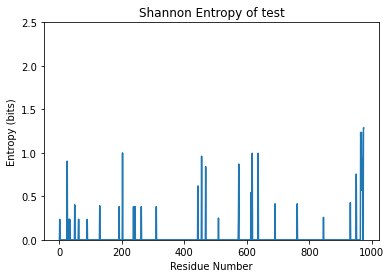

In [44]:
ylim = max(max(entropies), 2.5)

plt.ylim(0,ylim);
plt.plot(entropies);
plt.xlabel("Residue Number");
plt.ylabel("Entropy (bits)");
plt.title("Shannon Entropy of "+jobname_unhashed);
plt.savefig(jobname + "_Entropy_MaskedNG");

In [45]:
pwd

'/content/NLRome_Align_Tree/Maize_NLRome/test_2070a'